<a href="https://colab.research.google.com/github/PratikHazarika/AI-ML-Projects/blob/main/Prediction/Ethereum%20Price%20Prediction/src/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dowloading packages

In [2]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


# Loading packages

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
from datetime import date

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


# Downloading the dataset

In [7]:
today = date.today()

ticker = 'ETH-USD'
start_date = '2015-07-01'
end_date = today.strftime("%Y-%m-%d")


df = yf.download(tickers=ticker, 
                  start = start_date, 
                  end = end_date, 
                  progress=False
                )

# Cleaning the dataset

In [8]:
df['Date'] = df.index                   # making Date feature from index                                                      
df.reset_index(drop=True, inplace=True) # removing index

df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True) # removing irrelevant columns

new_cols = ['Date', 'Close']                                                  # swapping Date and Close 
df = df.reindex(columns = new_cols)

date_df = df.copy() # date_df = close_stock 
df.drop(['Date'], axis=1, inplace=True) 

# Normalizing the input

In [9]:
scaler = MinMaxScaler(feature_range = (0,1))
df = scaler.fit_transform(np.array(df).reshape(-1,1))

# Splitting train and test

In [10]:
train_len = int(df.shape[0] * 0.90)
test_len = int(df.shape[0] - train_len)

train_data = df[:train_len]
test_data = df[train_len:]

# Creating time-series data

In [11]:
def create_ts_dataset(dataset, time_step=1):
    train_data, test_data = [], []

    for i in range(len(dataset)-time_step-1):
        value = dataset[i : (i+time_step), 0]   
        train_data.append(value)
        test_data.append(dataset[i + time_step, 0])

    return np.array(train_data), np.array(test_data)

In [12]:
time_step = 20
X_train, y_train = create_ts_dataset(train_data, time_step)
X_test, y_test = create_ts_dataset(test_data, time_step)

# Reshaping train and test into 3dim for LSTM

In [13]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (1551, 20, 1)
X_test:  (154, 20, 1)


# Training the model

In [14]:
model = Sequential()

model.add(LSTM(units = 50,input_shape = (None,1), activation="relu", return_sequences = True))
model.add(Dropout(0.3))
model.add(LSTM(units = 40,activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(units = 1, activation = "linear"))

model.compile(loss="mse", optimizer = Adam(learning_rate=1e-3, epsilon = 1e-6))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 50)          10400     
                                                                 
 dropout (Dropout)           (None, None, 50)          0         
                                                                 
 lstm_1 (LSTM)               (None, 40)                14560     
                                                                 
 dropout_1 (Dropout)         (None, 40)                0         
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 25,001
Trainable params: 25,001
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=90,batch_size=32,verbose=1) 

Epoch 1/90
49/49 [==============================] - 5s 32ms/step - loss: 0.0253 - val_loss: 0.0051
Epoch 2/90
49/49 [==============================] - 1s 20ms/step - loss: 0.0058 - val_loss: 0.0065
Epoch 3/90
49/49 [==============================] - 1s 20ms/step - loss: 0.0048 - val_loss: 0.0029
Epoch 4/90
49/49 [==============================] - 1s 20ms/step - loss: 0.0043 - val_loss: 0.0029
Epoch 5/90
49/49 [==============================] - 1s 20ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 6/90
49/49 [==============================] - 1s 20ms/step - loss: 0.0043 - val_loss: 0.0028
Epoch 7/90
49/49 [==============================] - 1s 20ms/step - loss: 0.0041 - val_loss: 0.0050
Epoch 8/90
49/49 [==============================] - 1s 20ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 9/90
49/49 [==============================] - 1s 20ms/step - loss: 0.0039 - val_loss: 0.0023
Epoch 10/90
49/49 [==============================] - 1s 20ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 11/

# Saving the and loading the model

In [16]:
model.save('gdrive/MyDrive/Colab Notebooks/Stock Price Prediction/model.h5')

In [17]:
model = load_model('gdrive/MyDrive/Colab Notebooks/Stock Price Prediction/model.h5')

# Train Loss vs Validation Loss

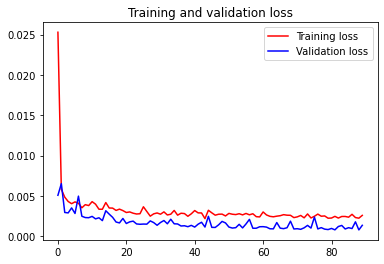

<Figure size 432x288 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

# Plotting actual vs predicted price

In [21]:
look_back = time_step

trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back : len(train_predict) + look_back, :] = train_predict

testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2) + 1 : len(df) - 1, :] = test_predict

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'date': date_df['Date'],
                       'original_close': date_df['Close'],
                       'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                       'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()
                       })

fig = px.line(plotdf, 
              x = plotdf['date'], 
              y = [plotdf['original_close'], plotdf['train_predicted_close'], plotdf['test_predicted_close']],
              labels = {'value':'Stock price','date': 'Date'})

fig.update_layout(title_text = 'Orginal Price vs Predicted Price',
                  plot_bgcolor='white', 
                  font_size=15, 
                  font_color='black', 
                  legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.show()

# Predicting next 30 days

In [31]:
x_input=test_data[len(test_data) - time_step :].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = time_step
pred_days = 30

for i in range(pred_days):
    
    if len(temp_input) > time_step:
        
        x_input = np.array(temp_input[1 : ])
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        y_pred = model.predict(x_input, verbose=0)
        temp_input.extend(y_pred[0].tolist())
        temp_input = temp_input[1 : ]
       
        lst_output.extend(y_pred.tolist())
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))

        y_pred = model.predict(x_input, verbose=0)

        temp_input.extend(y_pred[0].tolist())
        
        lst_output.extend(y_pred.tolist())
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


In [32]:
last_days = np.arange(1, time_step + 1)
day_pred = np.arange(time_step + 1, time_step + pred_days + 1)

In [33]:
temp_mat = np.empty((len(last_days)+pred_days + 1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0 : time_step + 1] = scaler.inverse_transform(df[len(df) - time_step : ]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step + 1 : ] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
    })

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot, 
              x = new_pred_plot.index, 
              y = [new_pred_plot['last_original_days_value'], new_pred_plot['next_predicted_days_value']],
              labels = {'value': 'Stock price','index': 'Timestamp'}
              )

fig.update_layout(title_text = 'Compare last 15 days vs next 30 days',
                  plot_bgcolor = 'white', 
                  font_size = 15, 
                  font_color = 'black',
                  legend_title_text = 'Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

# Price with prediction



In [34]:
lstmdf = df.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf = scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf, labels = {'value': 'Stock price','index': 'Timestamp'})

fig.update_layout(title_text = 'Plotting whole closing stock price with prediction',
                  plot_bgcolor ='white', 
                  font_size = 15, 
                  font_color = 'black',
                  legend_title_text = 'Stock'
                  )

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()